In [132]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import integrate

%matplotlib inline

[[1510594080346.5 -1.1769999999999998 -6.932 6.353000000000001]]


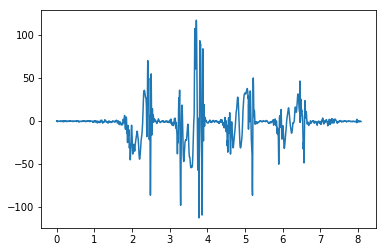

In [58]:
file = 'datas/walk40hz.tsv'
sep = '\t'
data = pd.read_csv(file, sep)
data = data.as_matrix()[:, 1:5]

means = np.mean(data[0:10, :], axis=0, keepdims=True)
print(means)

data[:, 0] = (data[:, 0] - data[0, 0]) / 1000.0 # timestamp -> microsecond -> second
data[:, 1:4] = (data[:, 1:4] - means[0, 1:4]) * 9.8 # g to m/s^2

plt.plot(data[:, 0], data[:, 1])

[[ 4.61783488 -1.02845992 -0.287616   -0.02510961]]


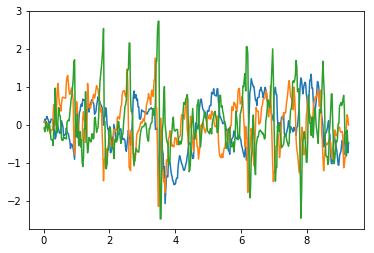

In [105]:
file = 'datas/walk_1.csv'
sep = ','
data = pd.read_csv(file, sep)
data = data.as_matrix()
data = data[~np.isnan(data).any(axis=1)] # remove row contains nan value

data[:, 3] = data[:, 3] - 9.8
means = np.mean(data, axis=0, keepdims=True)
print(means)

data[:, 1:4] = data[:, 1:4] - means[:, 1:4]

plt.plot(data[:, 0], data[:, 1:4])

In [106]:
class KalmanFilter:
    '''
    Ref: https://malcolmmielle.wordpress.com/2015/04/29/kalman-filter/
    '''
    
    def __init__(self, q, r, p):
        '''
        _q: process noise covariance
        _q_init
        _r: measurement noise covariance
        _r_init
        _p: estimation error covariance
        _p_init
        _x: value
        _k: Kalman gain
        '''
        self._q = float(q)
        self._q_init = float(q)
        self._r = float(r)
        self._r_init = float(r)
        self._x = 0
        self._p = float(p)
        self._p_init = float(p)
        self._k = float(p / (p + r))
        
    
    def init_value(self, x):
        self._x = float(x)
        
    def set_process_noise_covariance(self, i):
        self._q = float(i)
        self._q_init = float(i)
        
    def set_measurement_noise_covariance(self, i):
        self._r = float(i)
        self._r_init = float(i)
        
    def set_estimation_error_covariance(self, i):
        self._p = float(i)
        self._p_init = float(i)
        
    def kalman_update(self, measurement):
        # prediction update
        self._p = self._p + self._q
        
        # measurement update
        self._k = self._p / (self._p + self._r)
        self._x = self._x + self._k * (measurement - self._x)
        self._p = (1 - self._k) * self._p
        
        return self._x
    
    def reset(self):
        self._q = self._q_init
        self._r = self._r_init
        self._p = self._p_init
        

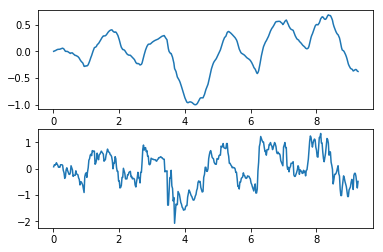

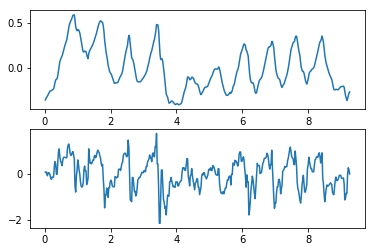

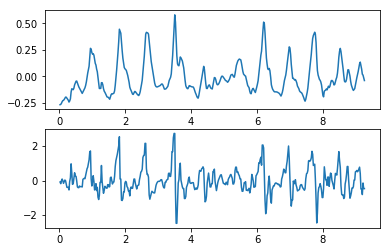

In [195]:
# Create KalmanFilter instance
q = 0.1
r = 32
p = 1
kfilter = KalmanFilter(q, r, p)

# Filter acceleration data
filtered_data = np.zeros((data.shape[0], 3))
for i in range(3):
    for j in range(data.shape[0]):
        filtered_data[j, i] = kfilter.kalman_update(data[j, i+1])
        filtered_data[j, i] = kfilter.kalman_update(filtered_data[j, i])
    
    # Plot data
    plt.figure(i+1)
    plt.subplot(211)
    plt.plot(data[:, 0], filtered_data[:, i])
    plt.subplot(212)
    plt.plot(data[:, 0], data[:, i+1])
    
    # Reset the filter
    kfilter.reset()


### Acceleration to distance

https://docs.scipy.org/doc/scipy/reference/integrate.html

https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html

https://engineersportal.com/blog/2017/9/25/accelerometer-on-an-elevator

https://www.researchgate.net/post/Calculating_Speed_and_Distance_from_a_3-axis_accelerometer

https://github.com/clemaitre58/Accelerometer_integration

https://www.nxp.com/docs/en/application-note/AN3397.pdf


(430,)
(430,)
(430,)
Distance travelled =  1.57788135811


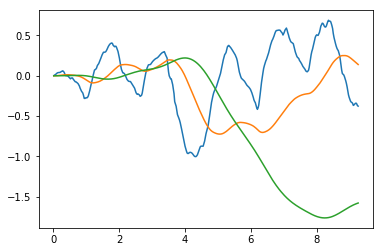

In [196]:
# acceleration data -> velocity -> distance

time = data[:, 0]
x_accel = filtered_data[:, 0]
x_velo = integrate.cumtrapz(x_accel, time, initial=0)
x_dist = integrate.cumtrapz(x_velo, time, initial=0)

print(time.shape)
print(x_velo.shape)
print(x_dist.shape)
print('Distance travelled = ', np.abs(x_dist[-1]))

# x_dist = integrate.simps(x_velo, time)
plt.plot(time, x_accel)
plt.plot(time, x_velo)
plt.plot(time, x_dist)

In [194]:
delta_x = np.mean(np.diff(time))
dx = delta_x.total_seconds()

AttributeError: 'numpy.float64' object has no attribute 'total_seconds'

### Final model